In [48]:
import numpy as np
import pandas as pd
from pathlib import Path
import pickle
from collections import Counter, defaultdict

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

%load_ext autoreload
%autoreload 2

from transformers import AutoTokenizer
from sklearn.metrics import mean_squared_error

from SemEval2020_Task10_Emphasis_Selection.try_it.How_to_Read_data_and_Write_results import (
    read_data,
    write_results,
)

import torch
import torch.nn as nn
import torch.nn.functional as F

from utils import get_df, match_m

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data

In [2]:
TRAIN_PATH = './SemEval2020_Task10_Emphasis_Selection/train_dev_data/train.txt'
VAL_PATH = './SemEval2020_Task10_Emphasis_Selection/train_dev_data/dev.txt'
TEST_PATH = './SemEval2020_Task10_Emphasis_Selection/test_data/test_data.txt'

In [3]:
train = get_df(TRAIN_PATH)
val = get_df(VAL_PATH)
test = get_df(TEST_PATH, is_test=True)

# Find `max_len` for `transformers` models

In [4]:
sentences_all = pd.concat([df['sentence'] for df in [train, val, test]]).reset_index(drop=True)

In [5]:
model_names = ['bert-large-cased', 'roberta-large', 'xlnet-large-cased']

for model_name in model_names:
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    sent_lengths = sentences_all.apply(lambda x: len(tokenizer.tokenize(x)))
    max_len = sent_lengths.max()
    arg_max_len = sent_lengths.argmax()
    print(f'{model_name:20}\t{max_len}\t({arg_max_len})')

bert-large-cased    	50	(138)
roberta-large       	49	(138)
xlnet-large-cased   	64	(138)


In [6]:
print(sentences_all.loc[138])
print(' '.join(tokenizer.tokenize(sentences_all.loc[138])))

The most exciting phrase to hear in science , the one that heralds new discoveries , is not ` Eureka ! ' -LRB- I 've found it ! -RRB- , but ` That 's funny ... ' .
▁The ▁most ▁exciting ▁phrase ▁to ▁hear ▁in ▁science ▁ , ▁the ▁one ▁that ▁herald s ▁new ▁discoveries ▁ , ▁is ▁not ▁` ▁Eu re ka ▁ ! ▁ ' ▁ - L RB - ▁I ▁ ' ve ▁found ▁it ▁ ! ▁ - R RB - ▁ , ▁but ▁` ▁That ▁ ' s ▁funny ▁ . . . ▁ ' ▁ .


In [ ]:
# taking into account special tokens max_len of 70 should be enough

# Predictions

## Load

In [13]:
# results for all models and all validation steps
results = pd.read_csv('results.csv')

In [14]:
results.head()

,model_name_or_path,label_mode,train_batch_size,accumulate_grad_batches,max_epochs,lr,frac_warmup_steps,weight_decay,random_seed,val_score1,val_score2,val_score3,val_score4,val_score_mean,val_loss,val_acc,val_f1,current_epoch,global_step
0,bert-large-cased,major,8,8,10,0.00005,0.05,0.0,19,0.100000,0.175000,0.282051,0.324324,0.220344,0.908148,0.266272,0.024096,0,0
1,bert-large-cased,major,8,8,10,0.00005,0.05,0.0,19,0.262755,0.450928,0.549242,0.624242,0.471792,0.611921,0.768073,0.000000,0,10
2,bert-large-cased,major,8,8,10,0.00005,0.05,0.0,19,0.448980,0.659151,0.757576,0.790909,0.664154,0.369429,0.826226,0.572697,0,21
3,bert-large-cased,major,8,8,10,0.00005,0.05,0.0,19,0.515306,0.718833,0.792614,0.821970,0.712181,0.313639,0.851995,0.587875,0,31
4,bert-large-cased,major,8,8,10,0.00005,0.05,0.0,19,0.591837,0.755968,0.812500,0.841667,0.750493,0.296016,0.862714,0.587919,0,42


In [16]:
# predicts for all models and all validation steps
PRED_DIR = Path('./predicts')

# each prediction is a dict
# {
#     'val': {
#         0: {  # number of epochs
#             100: [list with predictions],  # number of global step
              ...
#         },
          ...
#     },
#     'test': ... same as for val
# }

In [31]:
# load predictions to nested dict
predicts = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))))

for pred_file in PRED_DIR.iterdir():
    model_name_or_path, train_batch_size, accumulate_grad_batches, lr, label_mode, _ = pred_file.name.split('_')
    train_batch_size = int(train_batch_size.split('-')[1])
    accumulate_grad_batches = int(accumulate_grad_batches.split('-')[1])
    lr = float(lr.split('-', 1)[1])
    label_mode = label_mode.split('-')[1]
    with open(pred_file, 'rb') as f:
        predicts[model_name_or_path][label_mode][train_batch_size][accumulate_grad_batches][lr] = pickle.load(f)

## Best by validation score and loss

In [63]:
def get_prediction_by_keys(name, label_mode, bs, acc, lr, dataset, epoch, step):
    """Get prediction from nested dict"""
    return predicts[name][label_mode][bs][acc][lr][dataset][epoch][step]

In [138]:
# best results by validation score

main_cols = ['model_name_or_path', 'label_mode', 'train_batch_size', 'accumulate_grad_batches', 'lr']

(results.sort_values('val_score_mean', ascending=False)
        .drop_duplicates(main_cols)
        [main_cols + ['current_epoch', 'global_step', 'val_loss', 'val_score_mean']]
        .head(20))

,model_name_or_path,label_mode,train_batch_size,accumulate_grad_batches,lr,current_epoch,global_step,val_loss,val_score_mean
590,roberta-large,separate,8,4,0.00001,4,3276,0.347867,0.799326
1130,xlnet-large-cased,separate,4,4,0.00001,7,12335,0.338535,0.798930
642,roberta-large,separate,8,2,0.00001,3,5782,0.320483,0.797231
473,roberta-large,separate,8,32,0.00005,2,264,0.322064,0.794917
658,bert-large-cased,separate,8,16,0.00005,2,576,0.335760,0.792963
508,roberta-large,separate,8,16,0.00005,3,768,0.344317,0.789704
559,roberta-large,separate,8,8,0.00001,4,1925,0.333026,0.788636
701,bert-large-cased,separate,8,2,0.00001,2,4625,0.325822,0.787050
227,bert-large-cased,separate,8,32,0.00005,2,216,0.347615,0.786817
457,roberta-large,major,8,2,0.00001,3,682,0.270582,0.786505


In [139]:
# best results by validation loss
(results.sort_values('val_loss')
        .drop_duplicates(main_cols)
        [main_cols + ['current_epoch', 'global_step', 'val_loss', 'val_score_mean']]
        .head(20))

,model_name_or_path,label_mode,train_batch_size,accumulate_grad_batches,lr,current_epoch,global_step,val_loss,val_score_mean
255,roberta-large,major,8,32,0.00005,5,57,0.266895,0.779836
393,roberta-large,major,8,8,0.00001,4,210,0.267752,0.779808
313,roberta-large,major,8,16,0.00005,2,57,0.268305,0.778125
363,roberta-large,major,8,8,0.00005,2,115,0.269023,0.779072
404,roberta-large,major,8,4,0.00005,1,127,0.269560,0.766257
457,roberta-large,major,8,2,0.00001,3,682,0.270582,0.786505
351,roberta-large,major,8,16,0.00001,7,168,0.272439,0.769272
436,roberta-large,major,8,2,0.00005,1,340,0.273360,0.775666
8,bert-large-cased,major,8,8,0.00005,1,84,0.274163,0.758297
975,xlnet-large-cased,major,4,4,0.00005,3,641,0.274973,0.767182


In [59]:
# parameters of models with best score and best loss
best_val_score = results.loc[results['val_score_mean'].idxmax()]
best_val_loss = results.loc[results['val_loss'].idxmin()]

In [92]:
# best score predictions
best_val_score_pred_val = get_prediction_by_keys(
    best_val_score['model_name_or_path'],
    best_val_score['label_mode'],
    best_val_score['train_batch_size'],
    best_val_score['accumulate_grad_batches'],
    best_val_score['lr'],
    'val',
    best_val_score['current_epoch'],
    best_val_score['global_step'],
)

best_val_score_pred_test = get_prediction_by_keys(
    best_val_score['model_name_or_path'],
    best_val_score['label_mode'],
    best_val_score['train_batch_size'],
    best_val_score['accumulate_grad_batches'],
    best_val_score['lr'],
    'test',
    best_val_score['current_epoch'],
    best_val_score['global_step'],
)

# best loss predictions
best_val_loss_pred_val = get_prediction_by_keys(
    best_val_loss['model_name_or_path'],
    best_val_loss['label_mode'],
    best_val_loss['train_batch_size'],
    best_val_loss['accumulate_grad_batches'],
    best_val_loss['lr'],
    'val',
    best_val_loss['current_epoch'],
    best_val_loss['global_step'],
)

best_val_loss_pred_test = get_prediction_by_keys(
    best_val_loss['model_name_or_path'],
    best_val_loss['label_mode'],
    best_val_loss['train_batch_size'],
    best_val_loss['accumulate_grad_batches'],
    best_val_loss['lr'],
    'test',
    best_val_loss['current_epoch'],
    best_val_loss['global_step'],
)

In [93]:
# best score
tmp_pred = match_m(best_val_score_pred_val,
                   val['emphasis_probabilities'])

print(np.mean(list(tmp_pred.values())))
print(tmp_pred)

0.7993261766968662
{1: 0.6964285714285714, 2: 0.8129973474801061, 3: 0.8333333333333329, 4: 0.8545454545454545}


In [95]:
# score for best loss
tmp_pred = match_m(best_val_loss_pred_val,
                   val['emphasis_probabilities'])

print(np.mean(list(tmp_pred.values())))
print(tmp_pred)

0.7798356277343346
{1: 0.6607142857142857, 2: 0.7785145888594165, 3: 0.8285984848484845, 4: 0.8515151515151516}


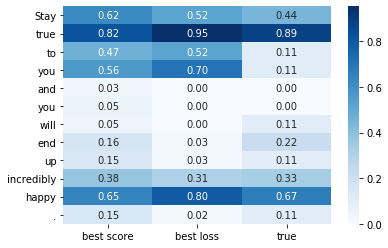

In [167]:
# plot prediction and true probs for val dataset

# all
# for pred, true, words in zip(best_val_score_pred_val, val['emphasis_probabilities'], val['words']):
#     sns.heatmap(np.array(list(zip(pred, true))), annot=True, yticklabels=words, cmap='Blues');
#     plt.show()
    
# random
i = np.random.choice(val.index)
sns.heatmap(np.array(list(zip(best_val_score_pred_val[i],
                              best_val_loss_pred_val[i],
                              val.loc[i, 'emphasis_probabilities']))),
            annot=True,
            fmt='.2f',
            yticklabels=val.loc[i, 'words'],
            xticklabels=['best score', 'best loss', 'true'],
            cmap='Blues');
plt.show()

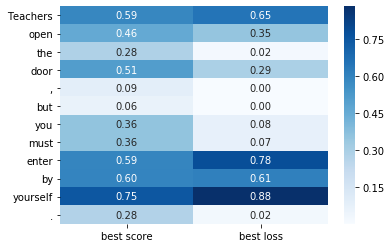

In [184]:
# plot prediction for test

# all
# for pred, words in zip(best_val_score_pred_test, test['words']):
#     sns.heatmap(np.array(pred).reshape(-1, 1), annot=True, yticklabels=words, cmap='Blues');
#     plt.show()
    
# random for best score and best loss
i = np.random.choice(val.index)
sns.heatmap(np.array([best_val_score_pred_test[i], best_val_loss_pred_test[i]]).T,
            annot=True, yticklabels=test.loc[i, 'words'], xticklabels=['best score', 'best loss'], cmap='Blues', fmt='.2f');
plt.show()

In [161]:
# make submission file best score
print(best_val_score)

model_name_or_path         roberta-large
label_mode                      separate
train_batch_size                       8
accumulate_grad_batches                4
max_epochs                            10
lr                                 1e-05
frac_warmup_steps                   0.05
weight_decay                           0
random_seed                           19
val_score1                      0.696429
val_score2                      0.812997
val_score3                      0.833333
val_score4                      0.854545
val_score_mean                  0.799326
val_loss                        0.347867
val_acc                         0.883238
val_f1                          0.640049
current_epoch                          4
global_step                         3276
Name: 590, dtype: object


In [165]:
write_results(word_id_lsts=test['word_ids'],
              words_lsts=test['words'],
              e_freq_lsts=best_val_score_pred_test,
              write_to='./submissions/submission_best_score.txt')

In [162]:
print(best_val_loss)

model_name_or_path         roberta-large
label_mode                         major
train_batch_size                       8
accumulate_grad_batches               32
max_epochs                            10
lr                                 5e-05
frac_warmup_steps                   0.05
weight_decay                           0
random_seed                           19
val_score1                      0.660714
val_score2                      0.778515
val_score3                      0.828598
val_score4                      0.851515
val_score_mean                  0.779836
val_loss                        0.266895
val_acc                         0.877309
val_f1                          0.619199
current_epoch                          5
global_step                           57
Name: 255, dtype: object


In [164]:
# make submission file best loss
write_results(word_id_lsts=test['word_ids'],
              words_lsts=test['words'],
              e_freq_lsts=best_val_loss_pred_test,
              write_to='./submissions/submission_best_loss.txt')

## Ensemble

In [154]:
# best results by validation score for bert, roberta and xlnet
best_scores = (results.sort_values('val_score_mean', ascending=False)
                      .drop_duplicates(['model_name_or_path'])
                      [main_cols + ['current_epoch', 'global_step', 'val_loss', 'val_score_mean']]
                      .head(20))

In [225]:
best_scores.T

,590,1130,658
model_name_or_path,roberta-large,xlnet-large-cased,bert-large-cased
label_mode,separate,separate,separate
train_batch_size,8,4,8
accumulate_grad_batches,4,4,16
lr,1e-05,1e-05,5e-05
current_epoch,4,7,2
global_step,3276,12335,576
val_loss,0.347867,0.338535,0.33576
val_score_mean,0.799326,0.79893,0.792963


In [155]:
# best results by validation loss for bert, roberta and xlnet
best_losses = (results.sort_values('val_loss')
                      .drop_duplicates(['model_name_or_path'])
                      [main_cols + ['current_epoch', 'global_step', 'val_loss', 'val_score_mean']]
                      .head(20))

In [226]:
best_losses.T

,255,8,975
model_name_or_path,roberta-large,bert-large-cased,xlnet-large-cased
label_mode,major,major,major
train_batch_size,8,8,4
accumulate_grad_batches,32,8,4
lr,5e-05,5e-05,5e-05
current_epoch,5,1,3
global_step,57,84,641
val_loss,0.266895,0.274163,0.274973
val_score_mean,0.779836,0.758297,0.767182


In [156]:
best_scores_val_preds = []

for _, row in best_scores.iterrows():
    pred_i = get_prediction_by_keys(
        row['model_name_or_path'],
        row['label_mode'],
        row['train_batch_size'],
        row['accumulate_grad_batches'],
        row['lr'],
        'val',
        row['current_epoch'],
        row['global_step'],
    )
    best_scores_val_preds.append(pred_i)

In [185]:
best_losses_val_preds = []

for _, row in best_losses.iterrows():
    pred_i = get_prediction_by_keys(
        row['model_name_or_path'],
        row['label_mode'],
        row['train_batch_size'],
        row['accumulate_grad_batches'],
        row['lr'],
        'val',
        row['current_epoch'],
        row['global_step'],
    )
    best_losses_val_preds.append(pred_i)

In [212]:
def get_ens_prediction(preds):
    out_preds = []
    for pred_i in zip(*preds):
        pred_i = np.array(list(pred_i))
        pred_i = list(pred_i.mean(axis=0))
        out_preds.append(pred_i)
        out_pred_i = np.mean
    return out_preds

In [216]:
ens_best_scores_val_preds = get_ens_prediction(best_scores_val_preds)
ens_best_losses_val_preds = get_ens_prediction(best_losses_val_preds)

In [217]:
# best scores ensemble
tmp_pred = match_m(ens_best_scores_val_preds,
                   val['emphasis_probabilities'])

print(np.mean(list(tmp_pred.values())))
print(tmp_pred)

0.8084845137415949
{1: 0.7040816326530612, 2: 0.8209549071618037, 3: 0.8437499999999996, 4: 0.8651515151515151}


In [218]:
# best losses ensemble
tmp_pred = match_m(ens_best_losses_val_preds,
                   val['emphasis_probabilities'])

print(np.mean(list(tmp_pred.values())))
print(tmp_pred)

0.7889252706447902
{1: 0.6658163265306123, 2: 0.7957559681697612, 3: 0.8342803030303027, 4: 0.8598484848484849}


### Ensemble predictions for test

In [221]:
best_scores_test_preds = []

for _, row in best_scores.iterrows():
    pred_i = get_prediction_by_keys(
        row['model_name_or_path'],
        row['label_mode'],
        row['train_batch_size'],
        row['accumulate_grad_batches'],
        row['lr'],
        'test',
        row['current_epoch'],
        row['global_step'],
    )
    best_scores_test_preds.append(pred_i)

best_losses_test_preds = []

for _, row in best_losses.iterrows():
    pred_i = get_prediction_by_keys(
        row['model_name_or_path'],
        row['label_mode'],
        row['train_batch_size'],
        row['accumulate_grad_batches'],
        row['lr'],
        'test',
        row['current_epoch'],
        row['global_step'],
    )
    best_losses_test_preds.append(pred_i)

In [222]:
ens_best_scores_test_preds = get_ens_prediction(best_scores_test_preds)
ens_best_losses_test_preds = get_ens_prediction(best_losses_test_preds)

In [223]:
# make submission file best scores ensemble
write_results(word_id_lsts=test['word_ids'],
              words_lsts=test['words'],
              e_freq_lsts=ens_best_scores_test_preds,
              write_to='./submissions/submission_best_scores_ens.txt')

In [224]:
# make submission file best losses ensemble
write_results(word_id_lsts=test['word_ids'],
              words_lsts=test['words'],
              e_freq_lsts=ens_best_losses_test_preds,
              write_to='./submissions/submission_best_losses_ens.txt')